In [1]:
import os
import sys
import torch
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')


In [2]:
ckpt_used_for_phi=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt')

# Extract phi from the checkpoint used for fixed phi work
if 'model_state_dict' in ckpt_used_for_phi and 'phi' in ckpt_used_for_phi['model_state_dict']:
    phi_fixed = ckpt_used_for_phi['model_state_dict']['phi']
elif 'phi' in ckpt_used_for_phi:
    phi_fixed = ckpt_used_for_phi['phi']
else:
    raise ValueError("No phi found in checkpoint")

# Convert to numpy if tensor
if torch.is_tensor(phi_fixed):
    phi_fixed = phi_fixed.detach().cpu().numpy()

print(f"Loaded phi from fixed phi checkpoint, shape: {phi_fixed.shape}")

Loaded phi from fixed phi checkpoint, shape: (21, 348, 52)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_51796/3728522181.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_used_for_phi=torch.load('/Users/sarahurb

In [5]:
tl=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/retrospective_pooled/batch_info.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_51796/975962336.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tl=torch.load('/Users/sarahurbut/Library/Cloud

In [6]:
tl

{'batches': [(390000, 400000)],
 'total_patients': 10000,
 'n_diseases': 348,
 'n_timepoints': 52,
 'args': {'trained_model_path': 'data_for_running/master_for_fitting_pooled_all_data.pt',
  'batch_size': 10000,
  'num_epochs': 200,
  'learning_rate': 0.1,
  'lambda_reg': 0.01,
  'data_dir': 'data_for_running/',
  'output_dir': './output/retrospective_pooled',
  'covariates_path': 'data_for_running/baselinagefamh_withpcs.csv',
  'include_pcs': True,
  'max_batches': 1,
  'start_batch': 39}}

In [22]:
import re
import pandas as pd
import numpy as np

# Parse the all_40_batches_latest file to extract AUCs per batch
results_file = '/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/all_40_batches_latest'

batch_aucs = {}  # {batch_idx: [list of AUCs]}

with open(results_file, 'r') as f:
    current_batch = None
    in_summary = False
    
    for line in f:
        # Detect batch start
        batch_match = re.search(r'Processing batch (\d+):', line)
        if batch_match:
            current_batch = int(batch_match.group(1))
            batch_aucs[current_batch] = []
            in_summary = False
            continue
        
        # Detect summary section start
        if 'Summary of Results (Dynamic 10-Year Risk' in line:
            in_summary = True
            continue
        
        # Extract AUC values from summary lines
        if in_summary and current_batch is not None:
            # Match lines like "ASCVD                0.654 (0.635-0.672)"
            auc_match = re.search(r'(\w+(?:_\w+)*)\s+(\d+\.\d+)', line)
            if auc_match:
                disease = auc_match.group(1)
                auc = float(auc_match.group(2))
                batch_aucs[current_batch].append(auc)

# Calculate mean AUC per batch
batch_performance = []
for batch_idx, aucs in batch_aucs.items():
    if len(aucs) > 0:
        batch_performance.append({
            'batch': batch_idx,
            'mean_auc': np.mean(aucs),
            'median_auc': np.median(aucs),
            'std_auc': np.std(aucs),
            'n_diseases': len(aucs)
        })

batch_df = pd.DataFrame(batch_performance).sort_values('mean_auc', ascending=False)

print("="*80)
print("Batch Performance Summary (sorted by mean AUC)")
print("="*80)
print(batch_df.to_string(index=False))

# Select top and worst performing batches
n_select = 5  # Top 5 and worst 5
top_batches = batch_df.head(n_select)['batch'].tolist()
worst_batches = batch_df.tail(n_select)['batch'].tolist()

# Also include batches 37, 38, 39 if not already selected
test_batches = list(set(top_batches + worst_batches + [37, 38, 39]))
test_batches = sorted(test_batches)[:10]  # Limit to 10 total

print(f"\n{'='*80}")
print(f"Selected batches for leave-one-out validation (up to 10):")
print(f"{'='*80}")
print(f"Top performing: {top_batches}")
print(f"Worst performing: {worst_batches}")
print(f"Final selection: {test_batches}")
print(f"{'='*80}")

# Store for use in leave-one-out checkpoint creation
test_batches_to_exclude = test_batches

Batch Performance Summary (sorted by mean AUC)
 batch  mean_auc  median_auc  std_auc  n_diseases
     6  0.613744      0.6125 0.072787         168
    20  0.613226      0.6180 0.076473         168
    15  0.612946      0.6105 0.073161         168
    35  0.612571      0.6055 0.078194         168
    18  0.612167      0.6080 0.087314         168
     5  0.611560      0.6080 0.081294         168
    22  0.611173      0.6010 0.074903         168
     1  0.611161      0.6125 0.071359         168
     3  0.610280      0.6065 0.080094         168
    16  0.610208      0.6125 0.088079         168
    11  0.609482      0.6110 0.073501         168
    30  0.609113      0.6185 0.080504         168
     4  0.609113      0.6085 0.092430         168
     9  0.609054      0.6020 0.082844         168
    12  0.609036      0.6075 0.072612         168
    13  0.609000      0.5955 0.075623         168
    31  0.608702      0.6095 0.079395         168
     8  0.608667      0.6025 0.086554         168
   

In [23]:
# Create leave-one-out checkpoints for all selected batches
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')
from create_leave_one_out_checkpoints import pool_phi_from_batches_excluding

# Load original pooled checkpoint to get exact psi
original_checkpoint_path = data_dir + 'master_for_fitting_pooled_all_data.pt'
original_checkpoint = torch.load(original_checkpoint_path, weights_only=False)
psi_from_original = original_checkpoint['model_state_dict']['psi']
if torch.is_tensor(psi_from_original):
    psi_from_original = psi_from_original.cpu().numpy()

print(f"Creating leave-one-out checkpoints for {len(test_batches_to_exclude)} batches...")
print(f"Batches: {test_batches_to_exclude}")

leave_one_out_results = {}
retrospective_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt'

for exclude_batch in test_batches_to_exclude:
    print(f"\n{'='*80}")
    print(f"Creating checkpoint excluding batch {exclude_batch}")
    print(f"{'='*80}")
    
    # Pool phi excluding this batch
    phi_retrospective_loo, included_indices = pool_phi_from_batches_excluding(
        retrospective_pattern,
        [exclude_batch],
        total_batches=40
    )
    
    # Create checkpoint with same psi as original
    output_path_loo = data_dir + f'master_for_fitting_pooled_all_data_exclude_batch_{exclude_batch}.pt'
    checkpoint = {
        'model_state_dict': {
            'phi': torch.tensor(phi_retrospective_loo, dtype=torch.float32),
            'psi': torch.tensor(psi_from_original, dtype=torch.float32),
        },
        'description': f"Pooled phi from retrospective batches excluding batch {exclude_batch}",
        'phi_shape': list(phi_retrospective_loo.shape),
        'psi_shape': list(psi_from_original.shape),
    }
    
    torch.save(checkpoint, output_path_loo)
    print(f"✓ Created: {output_path_loo}")
    
    leave_one_out_results[exclude_batch] = {
        'phi_pooled': phi_retrospective_loo,
        'included_indices': included_indices,
        'checkpoint_path': output_path_loo
    }

print(f"\n{'='*80}")
print(f"✓ Created {len(leave_one_out_results)} leave-one-out checkpoints!")
print(f"{'='*80}")

Creating leave-one-out checkpoints for 10 batches...
Batches: [0, 6, 15, 17, 18, 20, 24, 34, 35, 37]

Creating checkpoint excluding batch 0
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
  Excluding batch 0
  ✓ Included batch 1: enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
  ✓ Included batch 2: enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
  ✓ Included batch 3: enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
  ✓ Included batch 4: enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
  ✓ Included batch 5: enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348, 52)
  ✓ Included batch 6: enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348, 52)
  ✓ Included batch 7: enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348, 52)
  ✓ Included batch 8: enrollment_model_W0.0001_bat

In [24]:
tl=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data_exclude_batch_35.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_43511/616147373.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tl=torch.load("/Users/sarahurbut/Library/Cloud

In [ ]:
cd /Users/sarahurbut/aladynoulli2/claudefile

# Sequential version with nohup (runs one at a time, but persists if you disconnect)
nohup bash -c '
for batch in 0 6 15 17 18 20 24 34 35 37; do
    echo "Starting batch $batch..."
    python run_aladyn_predict_with_master.py \
        --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data_exclude_batch_${batch}.pt \
        --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/leave_one_out_validation/batch_${batch}/ \
        --start_batch ${batch} \
        --max_batches 1 \
        --data_dir /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/ \
        --covariates_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv
    echo "Completed batch $batch"
done
echo "All batches completed!"
' > predict_loo_all_batches.log 2>&1 &

echo "Sequential jobs started in background (PID: $!)"
echo "Monitor progress with: tail -f predict_loo_all_batches.log"


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_43511/1725952735.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tl=torch.load('/Users/sarahurbut/Library/Clou

tensor([-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -

In [18]:
disease_names

['Bacterial enteritis',
 'Viral Enteritis',
 'Gram negative septicemia',
 'Bacterial infection NOS',
 'Staphylococcus infections',
 'Streptococcus infection',
 'E. coli',
 'Viral warts & HPV',
 'Viral infection',
 'Candidiasis',
 'Colon cancer',
 'Malignant neoplasm of rectum, rectosigmoid junction, and anus',
 'Neoplasm of unspecified nature of digestive system',
 'Cancer of bronchus; lung',
 'Melanomas of skin',
 'Other non-epithelial cancer of skin',
 'Breast cancer [female]',
 'Malignant neoplasm of female breast',
 'Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]',
 'Malignant neoplasm of uterus',
 'Malignant neoplasm of ovary',
 'Cancer of prostate',
 'Malignant neoplasm of kidney, except pelvis',
 'Malignant neoplasm of bladder',
 'Malignant neoplasm, other',
 'Secondary malignant neoplasm',
 'Secondary malignancy of lymph nodes',
 'Secondary malignancy of respiratory organs',
 'Secondary malignant neoplasm of digestive systems',
 'Secondary malignant neoplasm of l

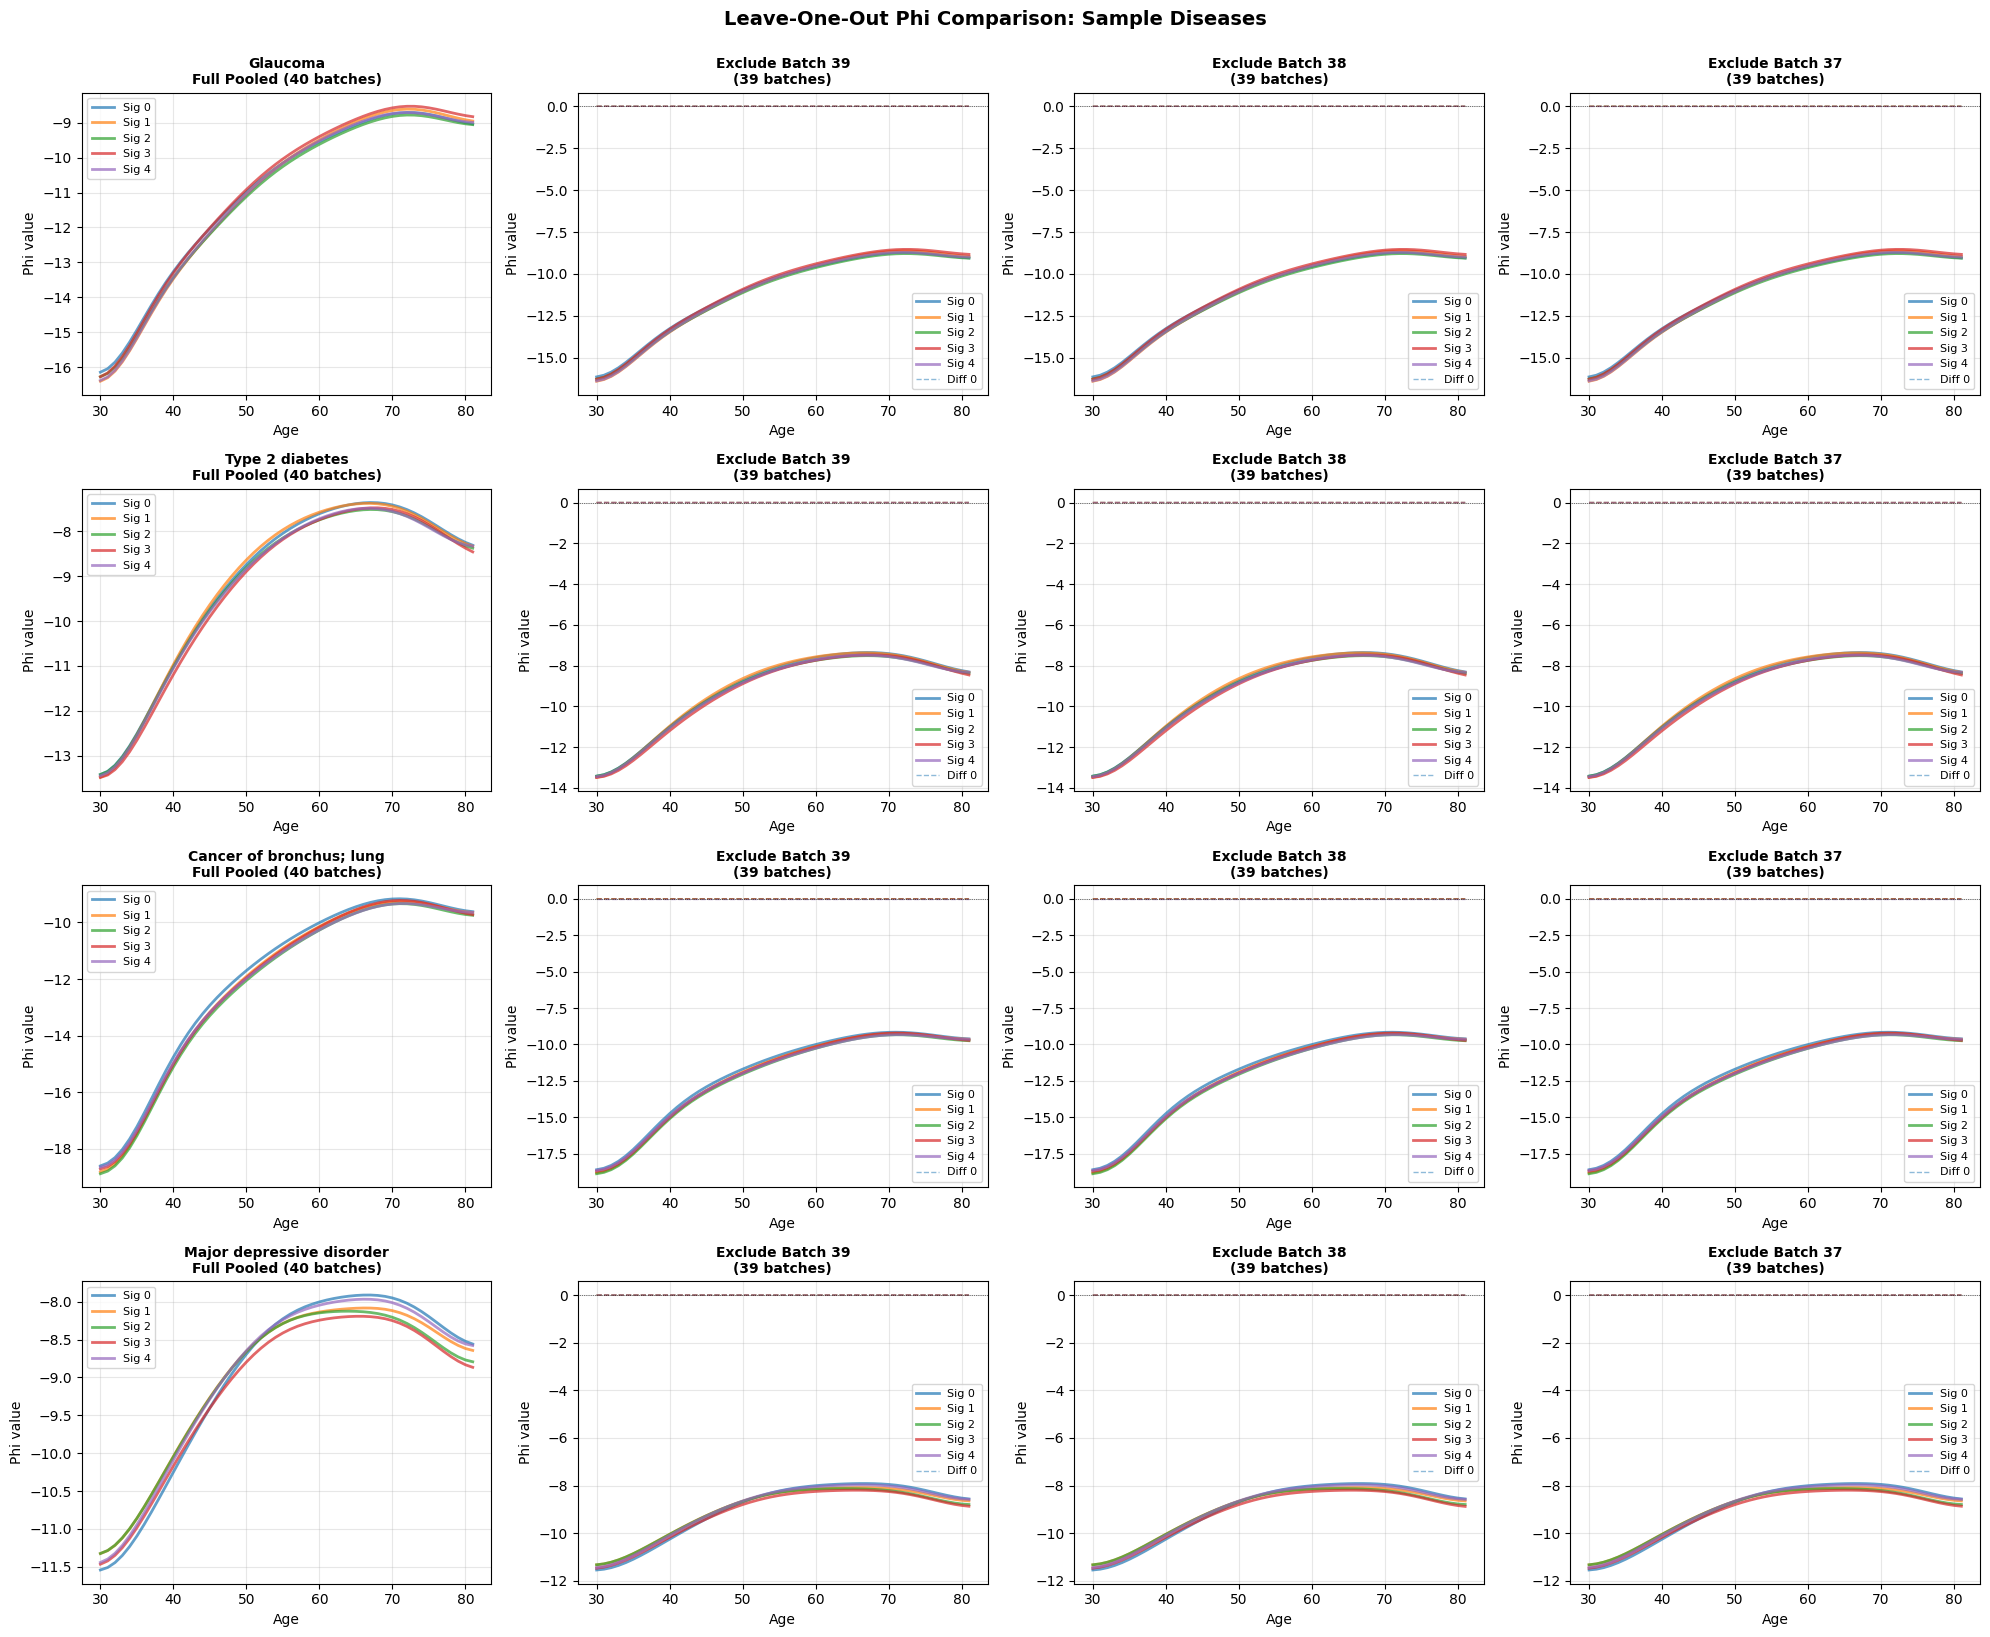

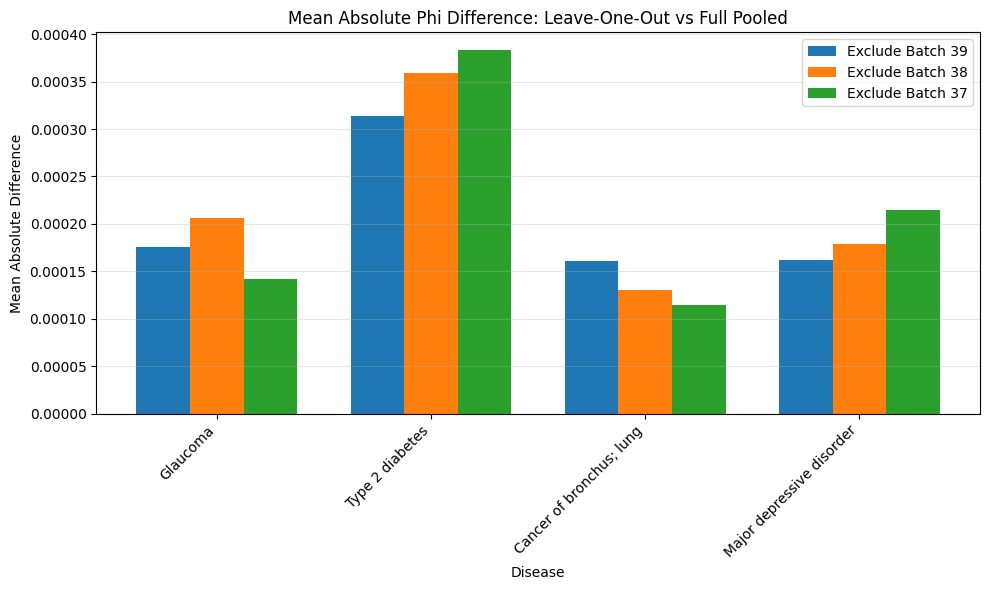


Summary of differences:

Glaucoma:
  Exclude batch 39: mean=0.000176, max=0.004662
  Exclude batch 38: mean=0.000206, max=0.008717
  Exclude batch 37: mean=0.000142, max=0.006002

Type 2 diabetes:
  Exclude batch 39: mean=0.000314, max=0.009720
  Exclude batch 38: mean=0.000359, max=0.010032
  Exclude batch 37: mean=0.000383, max=0.017311

Cancer of bronchus; lung:
  Exclude batch 39: mean=0.000161, max=0.004230
  Exclude batch 38: mean=0.000131, max=0.004142
  Exclude batch 37: mean=0.000114, max=0.004308

Major depressive disorder:
  Exclude batch 39: mean=0.000162, max=0.004305
  Exclude batch 38: mean=0.000179, max=0.006473
  Exclude batch 37: mean=0.000215, max=0.005939


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Load original full pooled phi
original_checkpoint_path = data_dir + 'master_for_fitting_pooled_all_data.pt'
original_checkpoint = torch.load(original_checkpoint_path, weights_only=False)
phi_full_pooled = original_checkpoint['model_state_dict']['phi']
if torch.is_tensor(phi_full_pooled):
    phi_full_pooled = phi_full_pooled.cpu().numpy()

# Get disease names (assuming you have essentials loaded)
# If not, you can load from model_essentials.pt
essentials = torch.load(data_dir + 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']

# Select a few sample diseases to plot (e.g., ASCVD, Diabetes, Atrial_Fib, CKD, All_Cancers)
sample_diseases = ['Myocardial_Infarction', 'Glaucoma', 'Type 2 diabetes', 'Cancer of bronchus; lung', 'Major depressive disorder']
disease_indices = [disease_names.index(d) for d in sample_diseases if d in disease_names]

# Create figure with subplots
n_diseases = len(disease_indices)
n_batches = len(test_batches_to_exclude)
fig, axes = plt.subplots(n_diseases, n_batches + 1, figsize=(5*(n_batches+1), 4*n_diseases))

if n_diseases == 1:
    axes = axes.reshape(1, -1)
if n_batches == 0:
    axes = axes.reshape(-1, 1)

# Time points (ages 30-81)
time_points = np.arange(52) + 30

# Plot for each disease
for disease_idx, disease_name_idx in enumerate(disease_indices):
    disease_name = disease_names[disease_name_idx]
    
    # Plot full pooled phi (first column)
    ax = axes[disease_idx, 0]
    for k in range(min(5, phi_full_pooled.shape[0])):  # Plot first 5 signatures
        ax.plot(time_points, phi_full_pooled[k, disease_name_idx, :], 
                label=f'Sig {k}', alpha=0.7, linewidth=2)
    ax.set_title(f'{disease_name}\nFull Pooled (40 batches)', fontsize=10, fontweight='bold')
    ax.set_xlabel('Age')
    ax.set_ylabel('Phi value')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot each leave-one-out phi
    for batch_idx, exclude_batch in enumerate(test_batches_to_exclude):
        ax = axes[disease_idx, batch_idx + 1]
        
        # Load leave-one-out phi
        loo_checkpoint_path = data_dir + f'master_for_fitting_pooled_all_data_exclude_batch_{exclude_batch}.pt'
        loo_checkpoint = torch.load(loo_checkpoint_path, weights_only=False)
        phi_loo = loo_checkpoint['model_state_dict']['phi']
        if torch.is_tensor(phi_loo):
            phi_loo = phi_loo.cpu().numpy()
        
        # Plot phi values
        for k in range(min(5, phi_loo.shape[0])):  # Plot first 5 signatures
            ax.plot(time_points, phi_loo[k, disease_name_idx, :], 
                    label=f'Sig {k}', alpha=0.7, linewidth=2)
        
        # Overlay difference from full pooled (as dashed line)
        for k in range(min(5, phi_loo.shape[0])):
            diff = phi_loo[k, disease_name_idx, :] - phi_full_pooled[k, disease_name_idx, :]
            ax.plot(time_points, diff, '--', alpha=0.5, linewidth=1, 
                   color=plt.cm.tab10(k), label=f'Diff {k}' if k == 0 else '')
        
        ax.set_title(f'Exclude Batch {exclude_batch}\n({len(leave_one_out_results[exclude_batch]["included_indices"])} batches)', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Age')
        ax.set_ylabel('Phi value')
        ax.axhline(y=0, color='black', linestyle=':', linewidth=0.5)
        ax.legend(fontsize=8, loc='best')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Leave-One-Out Phi Comparison: Sample Diseases', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Also create a summary plot showing mean absolute differences
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))

mean_diffs_by_disease = {}
for disease_name_idx in disease_indices:
    disease_name = disease_names[disease_name_idx]
    mean_diffs = []
    for exclude_batch in test_batches_to_exclude:
        loo_checkpoint_path = data_dir + f'master_for_fitting_pooled_all_data_exclude_batch_{exclude_batch}.pt'
        loo_checkpoint = torch.load(loo_checkpoint_path, weights_only=False)
        phi_loo = loo_checkpoint['model_state_dict']['phi']
        if torch.is_tensor(phi_loo):
            phi_loo = phi_loo.cpu().numpy()
        
        diff = np.abs(phi_loo[:, disease_name_idx, :] - phi_full_pooled[:, disease_name_idx, :])
        mean_diffs.append(diff.mean())
    mean_diffs_by_disease[disease_name] = mean_diffs

# Use actual number of diseases found, not sample_diseases length
x = np.arange(len(disease_indices))
width = 0.25
for i, exclude_batch in enumerate(test_batches_to_exclude):
    values = [mean_diffs_by_disease[disease_names[disease_indices[j]]][i] 
              for j in range(len(disease_indices))]
    ax2.bar(x + i*width, values, width, label=f'Exclude Batch {exclude_batch}')

ax2.set_xlabel('Disease')
ax2.set_ylabel('Mean Absolute Difference')
ax2.set_title('Mean Absolute Phi Difference: Leave-One-Out vs Full Pooled')
ax2.set_xticks(x + width * (len(test_batches_to_exclude) - 1) / 2)
ax2.set_xticklabels([disease_names[i] for i in disease_indices], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nSummary of differences:")
for disease_name_idx in disease_indices:
    disease_name = disease_names[disease_name_idx]
    print(f"\n{disease_name}:")
    for exclude_batch in test_batches_to_exclude:
        loo_checkpoint_path = data_dir + f'master_for_fitting_pooled_all_data_exclude_batch_{exclude_batch}.pt'
        loo_checkpoint = torch.load(loo_checkpoint_path, weights_only=False)
        phi_loo = loo_checkpoint['model_state_dict']['phi']
        if torch.is_tensor(phi_loo):
            phi_loo = phi_loo.cpu().numpy()
        
        diff = np.abs(phi_loo[:, disease_name_idx, :] - phi_full_pooled[:, disease_name_idx, :])
        print(f"  Exclude batch {exclude_batch}: mean={diff.mean():.6f}, max={diff.max():.6f}")

In [9]:
import torch
checkpoint = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt', weights_only=False)
print('Has phi:', 'phi' in checkpoint)
print('Phi shape:', checkpoint['phi'].shape if 'phi' in checkpoint else 'N/A')
print('gamma shape:', checkpoint['model_state_dict']['gamma'].shape if 'model_state_dict' in checkpoint and 'gamma' in checkpoint['model_state_dict'] else 'N/A')

Has phi: True
Phi shape: torch.Size([21, 348, 52])
gamma shape: torch.Size([47, 21])


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def load_phis_from_batches(base_dir_pattern, max_batches=50):
    """
    Load phi from all batch files matching the pattern.
    
    Args:
        base_dir_pattern: Pattern like '/path/to/enrollment_model_W0.0001_batch_*_*.pt'
        max_batches: Maximum number of batches to load
    
    Returns:
        List of phi arrays
    """
    all_phis = []
    
    # Find all matching files
    files = sorted(glob.glob(base_dir_pattern))
    print(f"Found {len(files)} files matching pattern: {base_dir_pattern}")
    
    for file_path in files[:max_batches]:
        try:
            checkpoint = torch.load(file_path, weights_only=False)
            
            # Extract phi
            if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                phi = checkpoint['model_state_dict']['phi']
            elif 'phi' in checkpoint:
                phi = checkpoint['phi']
            else:
                print(f"Warning: No phi found in {file_path}")
                continue
            
            # Convert to numpy if tensor
            if torch.is_tensor(phi):
                phi = phi.detach().cpu().numpy()
            
            all_phis.append(phi)
            print(f"Loaded phi from {file_path}, shape: {phi.shape}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    return all_phis

def calculate_standard_errors(all_phis):
    """
    Calculate standard errors across batches for all phi parameters.
    
    Args:
        all_phis: List of phi arrays, each of shape (K, D, T)
    
    Returns:
        Array of standard errors for all K, D, T combinations
    """
    if len(all_phis) == 0:
        return None
    
    # Stack all phis: shape (n_batches, K, D, T)
    phi_stack = np.stack(all_phis, axis=0)
    n_batches = phi_stack.shape[0]
    
    # Calculate standard error for each (K, D, T) combination
    # SE = std / sqrt(n)
    std_phi = np.std(phi_stack, axis=0)  # (K, D, T)
    se_phi = std_phi / np.sqrt(n_batches)
    
    # Flatten to get all standard errors
    all_ses = se_phi.flatten()
    
    return all_ses, phi_stack

# Define the three configurations
configs = {
    'full_retrospective_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt',
    'fixed_phi_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_*_*.pt',
    'full_retrospective_no_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex/enrollment_model_W0.0001_batch_*_*.pt',
    'enrollment_joint_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
}

# Load phis for each configuration
results = {}
for config_name, pattern in configs.items():
    print(f"\n{'='*80}")
    print(f"Loading {config_name}")
    print(f"{'='*80}")
    all_phis = load_phis_from_batches(pattern)
    
    if len(all_phis) > 0:
        all_ses, phi_stack = calculate_standard_errors(all_phis)
        results[config_name] = {
            'all_ses': all_ses,
            'phi_stack': phi_stack,
            'n_batches': len(all_phis)
        }
        print(f"\n{config_name}: Loaded {len(all_phis)} batches")
        print(f"Standard Error Summary:")
        print(f"  Mean SE: {all_ses.mean():.4f}")
        print(f"  Median SE: {np.median(all_ses):.4f}")
        print(f"  95th percentile SE: {np.percentile(all_ses, 95):.4f}")
    else:
        print(f"Warning: No batches loaded for {config_name}")

print(f"\n{'='*80}")
print("Summary: All configurations loaded")
print(f"{'='*80}")


Loading full_retrospective_with_pcs
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded p

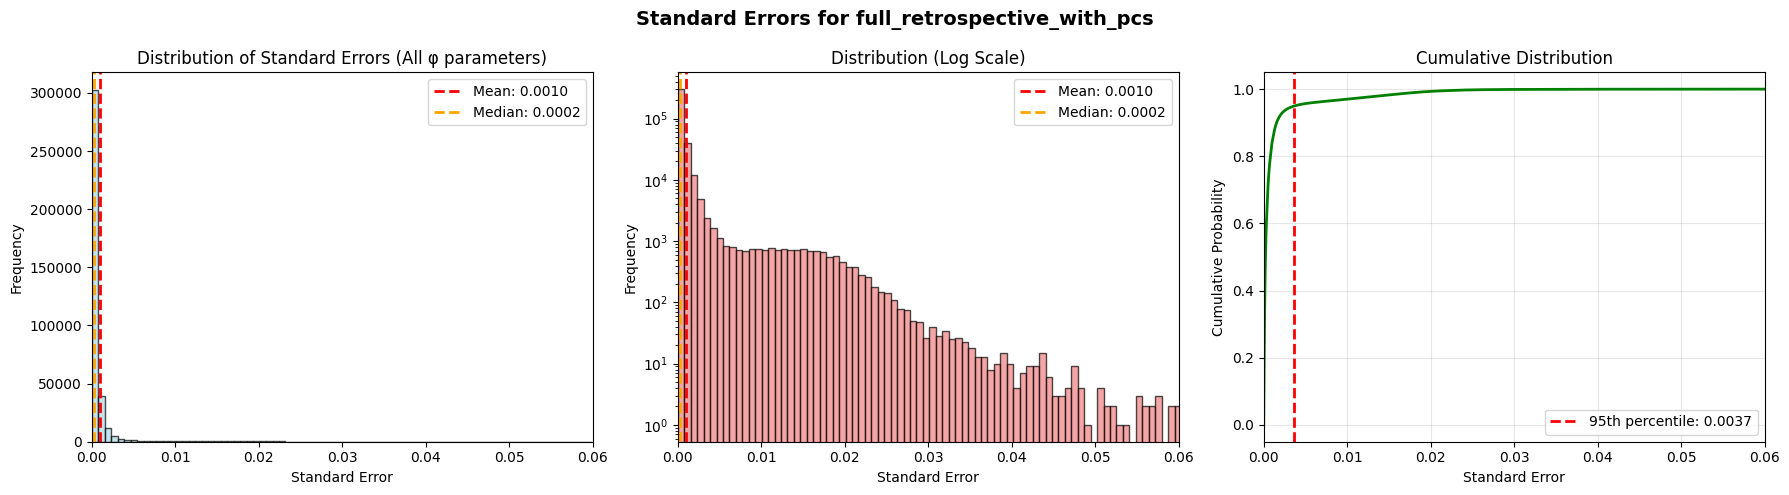

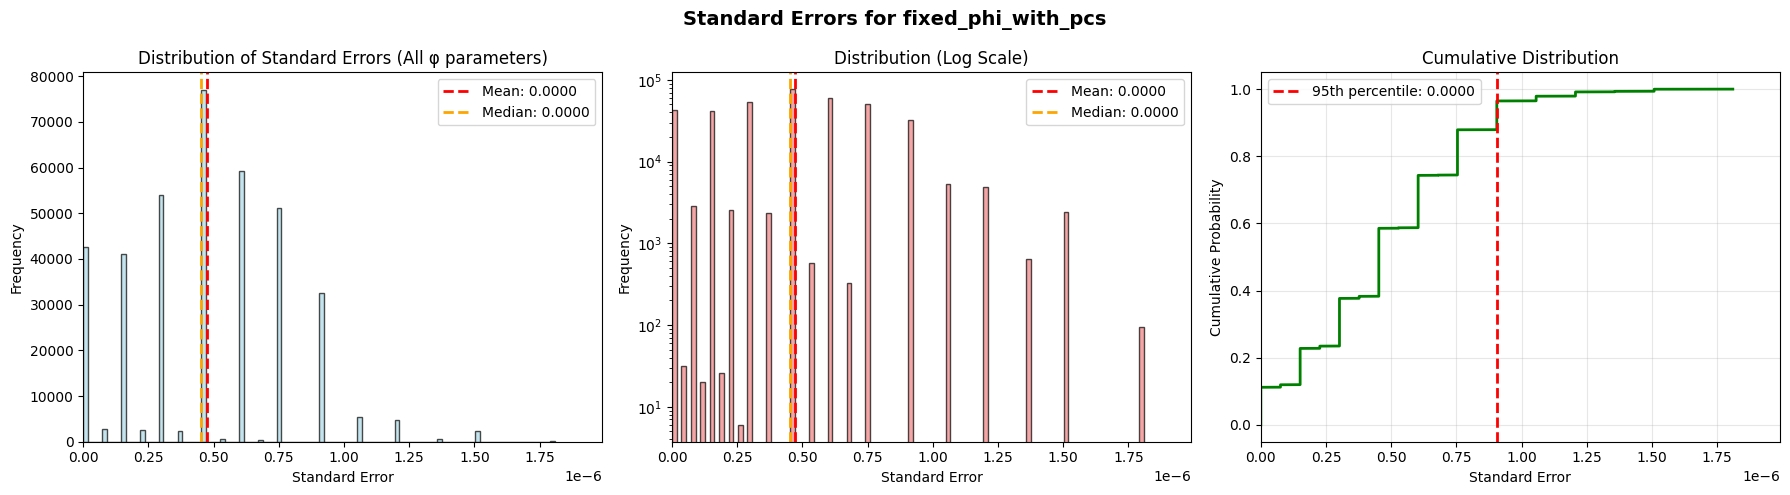

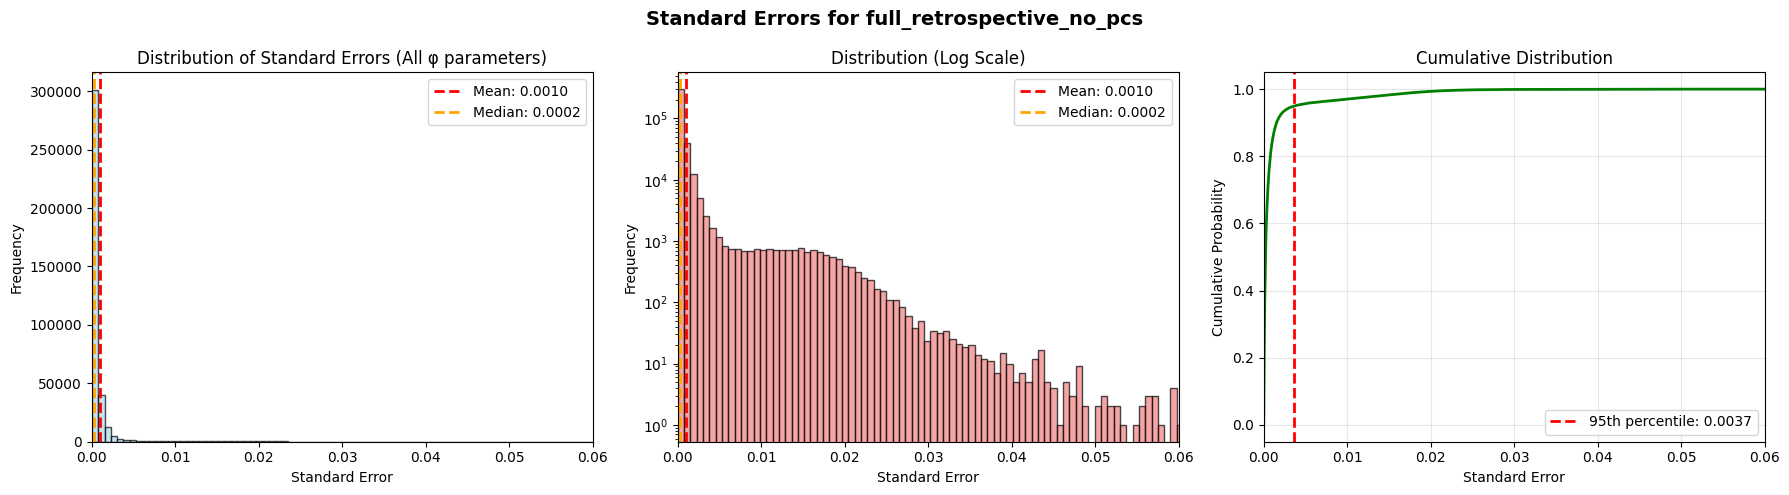

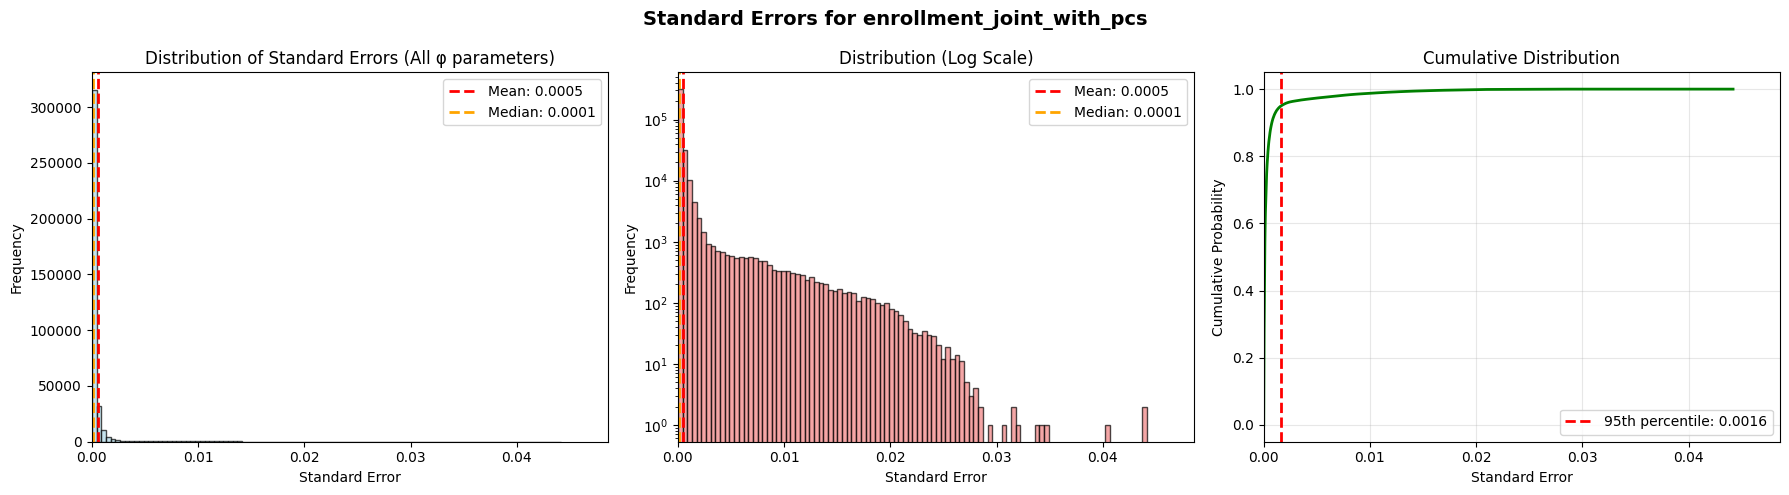


SUMMARY STATISTICS FOR ALL CONFIGURATIONS

full_retrospective_with_pcs (n_batches=40):
  Mean SE: 0.0010
  Median SE: 0.0002
  Max SE: 0.0773
  Min SE: 0.0000
  95th percentile SE: 0.0037
  99th percentile SE: 0.0181

fixed_phi_with_pcs (n_batches=40):
  Mean SE: 0.0000
  Median SE: 0.0000
  Max SE: 0.0000
  Min SE: 0.0000
  95th percentile SE: 0.0000
  99th percentile SE: 0.0000

full_retrospective_no_pcs (n_batches=40):
  Mean SE: 0.0010
  Median SE: 0.0002
  Max SE: 0.0757
  Min SE: 0.0000
  95th percentile SE: 0.0037
  99th percentile SE: 0.0181

enrollment_joint_with_pcs (n_batches=40):
  Mean SE: 0.0005
  Median SE: 0.0001
  Max SE: 0.0442
  Min SE: 0.0000
  95th percentile SE: 0.0016
  99th percentile SE: 0.0113


In [6]:
# Create the standard error distribution plot for each configuration
for config_name, result in results.items():
    all_ses = result['all_ses']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Standard Errors for {config_name}', fontsize=14, fontweight='bold')
    
    # Left plot: Distribution (Linear Scale)
    axes[0].hist(all_ses, bins=100, color='lightblue', edgecolor='black', alpha=0.7)
    mean_se = all_ses.mean()
    median_se = np.median(all_ses)
    axes[0].axvline(mean_se, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_se:.4f}')
    axes[0].axvline(median_se, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_se:.4f}')
    axes[0].set_xlabel('Standard Error')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Standard Errors (All φ parameters)')
    axes[0].legend()
    axes[0].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    
    # Middle plot: Distribution (Log Scale)
    axes[1].hist(all_ses, bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1].axvline(mean_se, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_se:.4f}')
    axes[1].axvline(median_se, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_se:.4f}')
    axes[1].set_xlabel('Standard Error')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution (Log Scale)')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    
    # Right plot: Cumulative Distribution
    sorted_ses = np.sort(all_ses)
    cumulative = np.arange(1, len(sorted_ses) + 1) / len(sorted_ses)
    axes[2].plot(sorted_ses, cumulative, color='green', linewidth=2)
    p95 = np.percentile(all_ses, 95)
    axes[2].axvline(p95, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {p95:.4f}')
    axes[2].set_xlabel('Standard Error')
    axes[2].set_ylabel('Cumulative Probability')
    axes[2].set_title('Cumulative Distribution')
    axes[2].legend()
    axes[2].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Print summary statistics for each configuration
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR ALL CONFIGURATIONS")
print("="*80)
for config_name, result in results.items():
    all_ses = result['all_ses']
    n_batches = result['n_batches']
    print(f"\n{config_name} (n_batches={n_batches}):")
    print(f"  Mean SE: {all_ses.mean():.4f}")
    print(f"  Median SE: {np.median(all_ses):.4f}")
    print(f"  Max SE: {all_ses.max():.4f}")
    print(f"  Min SE: {all_ses.min():.4f}")
    print(f"  95th percentile SE: {np.percentile(all_ses, 95):.4f}")
    print(f"  99th percentile SE: {np.percentile(all_ses, 99):.4f}")


In [19]:
#reproductibilit

old=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/models_fromAWS_enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/model_enroll_fixedphi_sex_380000_390000.pt')
temp=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/models_fromAWS_enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/retrospective_pooled/model_enroll_fixedphi_sex_380000_390000.pt')

np.allclose(old['model_state_dict']['lambda_'], temp['model_state_dict']['lambda_'])

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_51796/341868060.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  old=torch.load('/Users/sarahurbut/Library/Clou

True

In [28]:
temp=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/models_fromAWS_enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/retrospective_pooled/pi_enroll_fixedphi_sex_30000_40000.pt')
pi=torch.load('/Users/sarahurbut/Downloads/pi_full_400k.pt')
np.allclose(pi[30000:40000], temp)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_51796/804650017.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp=torch.load('/Users/sarahurbut/Library/Clo

True

Loading data...


/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/analyze_fh_carriers_signature.py:381: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta = torch.loa

Loading FH data from /Users/sarahurbut/Downloads/out/ukb_exome_450k_fh.carrier.txt...
FH data shape: (2573, 3)
Columns: ['IID', 'snp', 'genotype']...
Using ID column: IID
Loaded 2,155 FH carriers out of 400,000 total patients

FH CARRIERS: ENRICHMENT OF PRE-EVENT SIGNATURE RISE
Signature: 5
Window: last 5 years before first event; epsilon=0.0
Valid N with event & sufficient history: 56308
Carriers:   445/464 rising  (prop=0.959, CI95=(0.9369339508946029, 0.9736309252363722))
Noncarriers:52208/55844 rising  (prop=0.935, CI95=(0.9328137149837256, 0.9369065594482678))
Fisher exact (greater) OR=1.631, p=1.746e-02

✓ Saved results to results/fh_analysis


/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/analyze_fh_carriers_signature.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved plot to results/fh_analysis/FH_signature5_trajectory.png


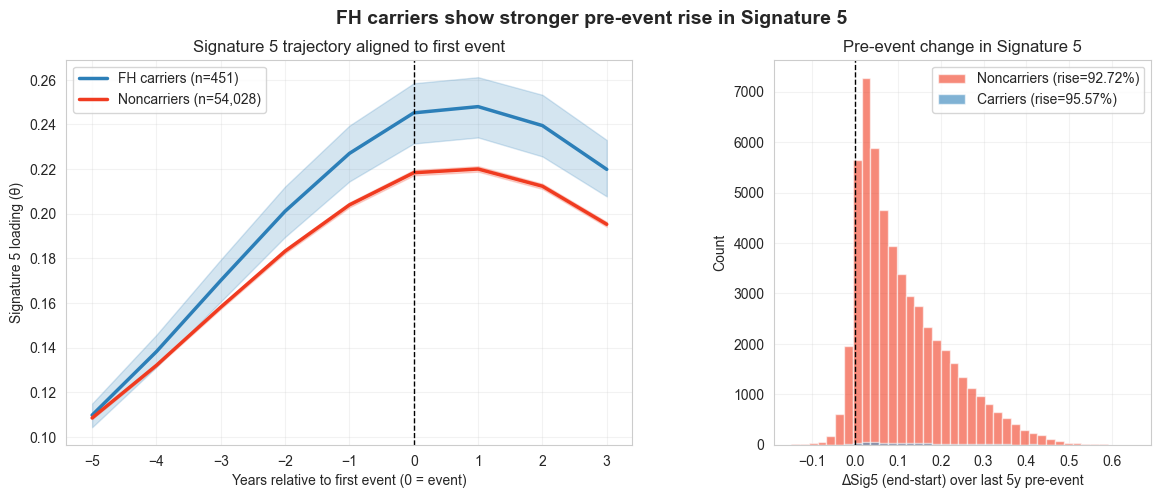

In [ ]:
%run analyze_fh_carriers_signature.py \
    --fh_file /Users/sarahurbut/Downloads/out/ukb_exome_450k_fh.carrier.txt \
    --signature_idx 5 \
    --event_indices 112,113,114,115,116 \
    --output_dir results/fh_analysis \
    --plot

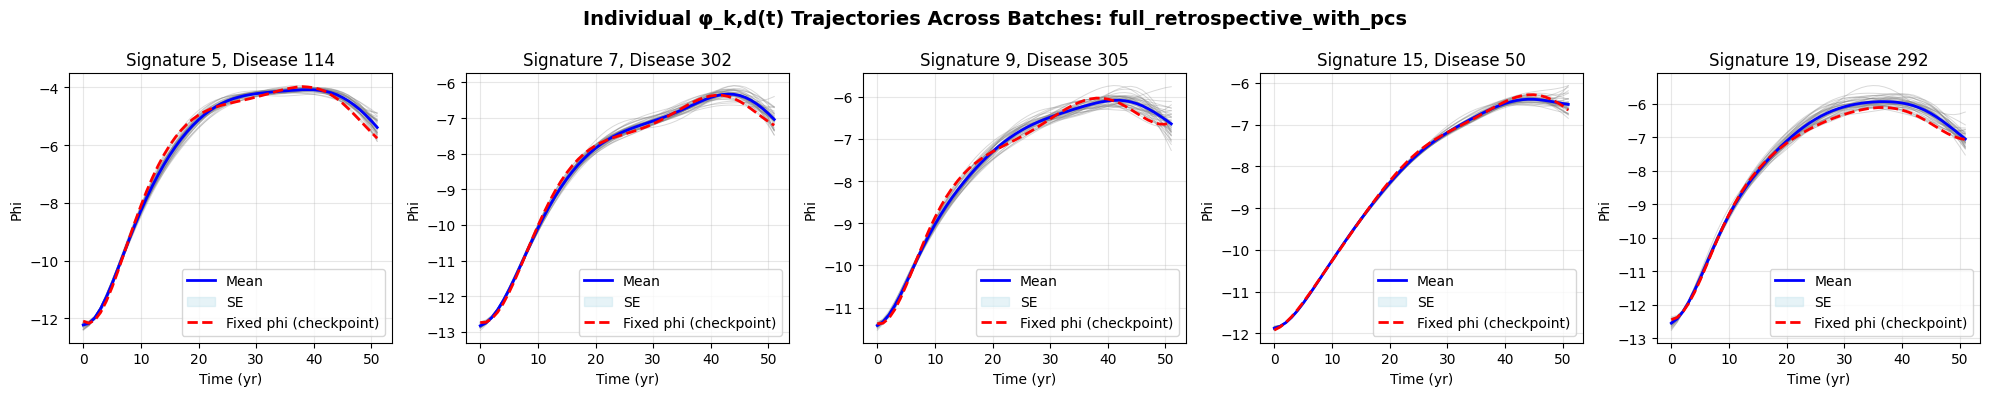


full_retrospective_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


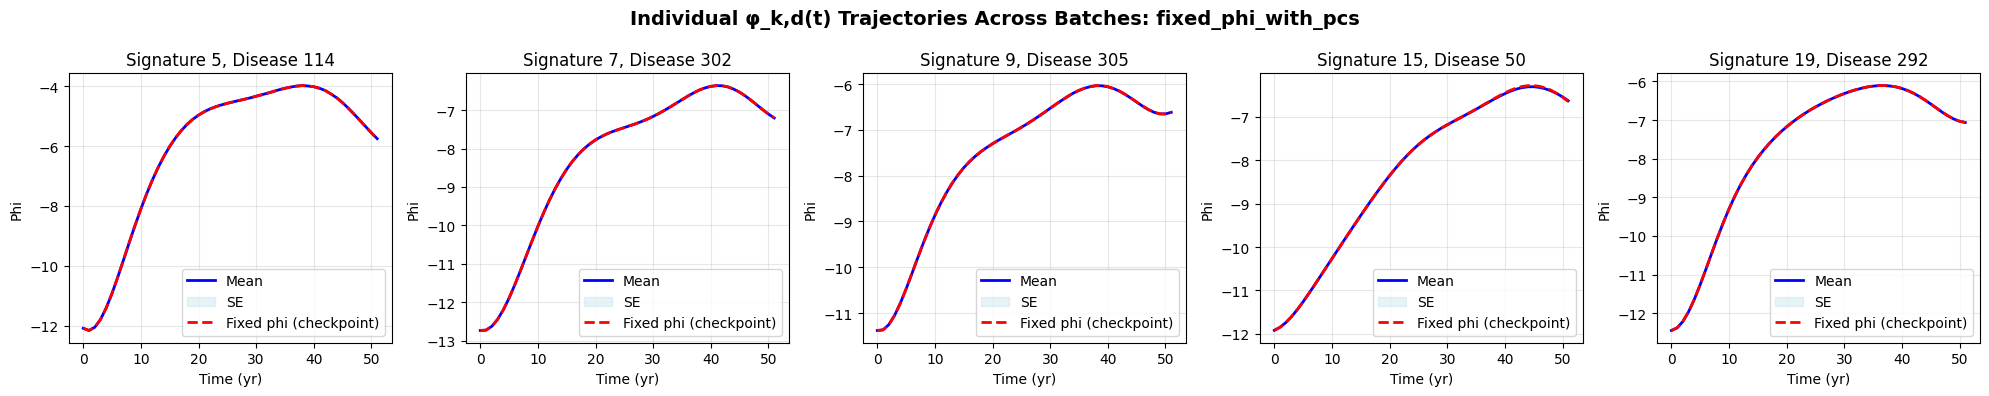


fixed_phi_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


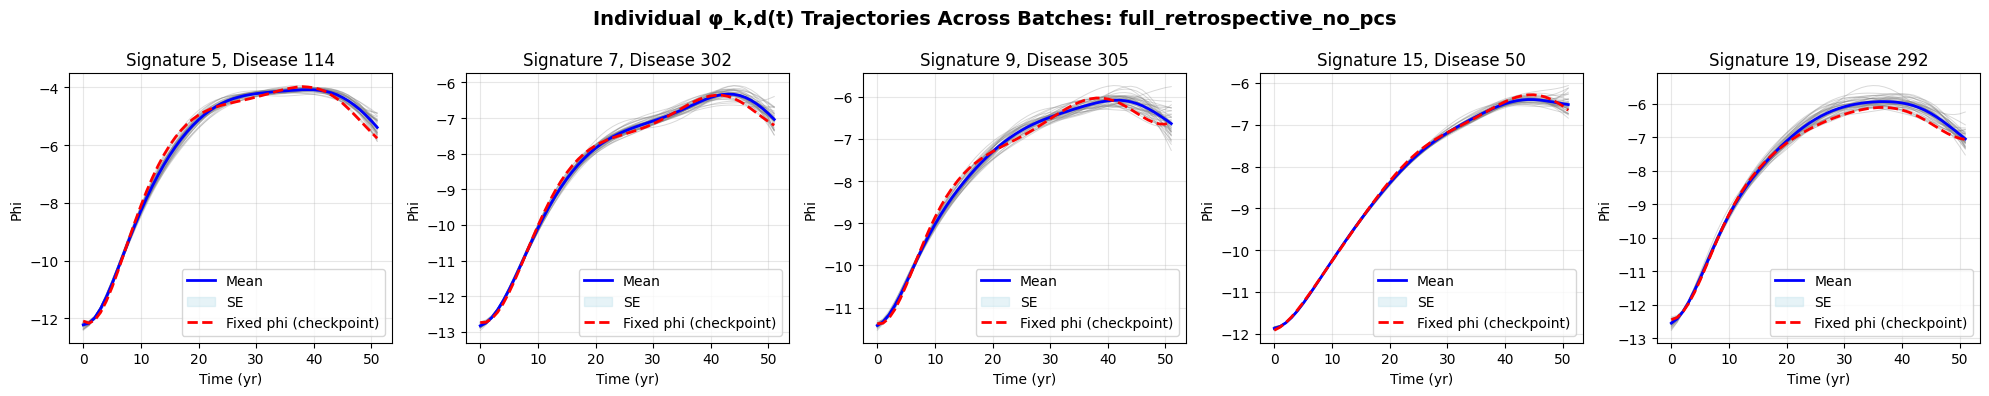


full_retrospective_no_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


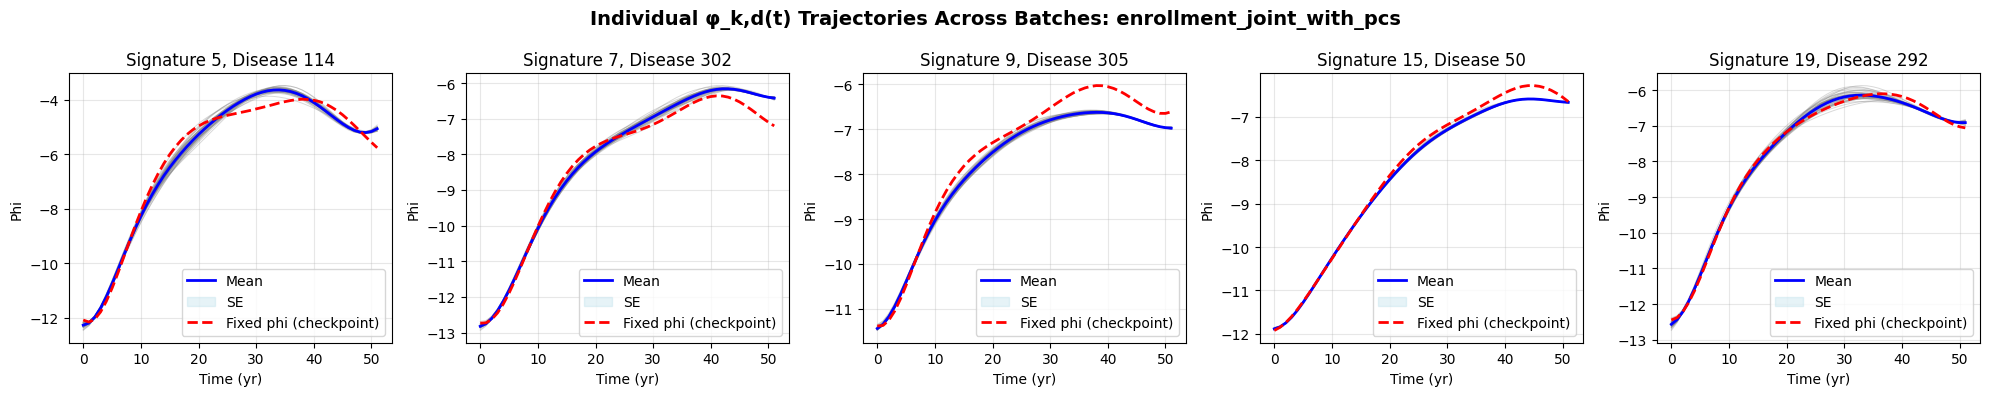


enrollment_joint_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


In [7]:
# Plot individual phi trajectories across batches (like Panel A in Figure S5)
# Using specific signature-disease pairs:
# Signature 5, Disease 114
# Signature 7, Disease 302
# Signature 9, Disease 305
# Signature 15, Disease 50
# Signature 19, Disease 292

signature_disease_pairs = [
    (5, 114),
    (7, 302),
    (9, 305),
    (15, 50),
    (19, 292)
]

for config_name, result in results.items():
    phi_stack = result['phi_stack']  # shape: (n_batches, K, D, T)
    n_batches, K, D, T = phi_stack.shape
    
    # Create figure with subplots for each signature-disease pair
    fig, axes = plt.subplots(1, len(signature_disease_pairs), figsize=(20, 4))
    fig.suptitle(f'Individual φ_k,d(t) Trajectories Across Batches: {config_name}', 
                 fontsize=14, fontweight='bold')
    
    time_points = np.arange(T)  # Assuming time points are 0, 1, 2, ..., T-1
    
    for idx, (k, d) in enumerate(signature_disease_pairs):
        if k >= K:
            print(f"Warning: Signature {k} not available (max K={K-1})")
            continue
        if d >= D:
            print(f"Warning: Disease {d} not available (max D={D-1})")
            continue
            
        # Get phi trajectories for this (k, d) across all batches
        phi_trajectories = phi_stack[:, k, d, :]  # shape: (n_batches, T)
        
        # Calculate mean and SE across batches
        mean_phi = phi_trajectories.mean(axis=0)  # shape: (T,)
        se_phi = phi_trajectories.std(axis=0) / np.sqrt(n_batches)  # shape: (T,)
        
        # Plot individual batch trajectories (gray lines)
        for b in range(n_batches):
            axes[idx].plot(time_points, phi_trajectories[b], 
                          color='gray', alpha=0.3, linewidth=0.7)
        
        # Plot mean trajectory (blue line)
        axes[idx].plot(time_points, mean_phi, color='blue', 
                      linewidth=2, label='Mean')
        
        # Plot SE region (light blue shaded)
        axes[idx].fill_between(time_points, 
                              mean_phi - se_phi, 
                              mean_phi + se_phi, 
                              color='lightblue', alpha=0.3, label='SE')
        
        # Plot fixed phi from checkpoint (red line)
        if phi_fixed is not None:
            phi_fixed_K, phi_fixed_D, phi_fixed_T = phi_fixed.shape
            if k < phi_fixed_K and d < phi_fixed_D:
                # Handle time dimension mismatch if needed
                if phi_fixed_T == T:
                    phi_fixed_traj = phi_fixed[k, d, :]
                elif phi_fixed_T > T:
                    phi_fixed_traj = phi_fixed[k, d, :T]
                else:
                    # If fixed phi has fewer time points, pad or interpolate
                    phi_fixed_traj = np.interp(time_points, 
                                             np.linspace(0, T-1, phi_fixed_T), 
                                             phi_fixed[k, d, :])
                axes[idx].plot(time_points, phi_fixed_traj, color='red', 
                              linewidth=2, linestyle='--', label='Fixed phi (checkpoint)')
        
        axes[idx].set_xlabel('Time (yr)')
        axes[idx].set_ylabel('Phi')
        axes[idx].set_title(f'Signature {k}, Disease {d}')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print confirmation
    print(f"\n{config_name} - Plotted signature-disease pairs:")
    for k, d in signature_disease_pairs:
        if k < K and d < D:
            print(f"  Signature {k}, Disease {d}")


In [10]:
from fig5utils import *
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

NameError: name 'essentials' is not defined

In [8]:
from create_master_checkpoints import *

In [3]:
# Import functions from create_master_checkpoints
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')
from create_master_checkpoints import pool_phi_from_batches, create_master_checkpoint

# Load initial_psi
data_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
initial_psi = torch.load(data_dir + 'initial_psi_400k.pt', weights_only=False)
if torch.is_tensor(initial_psi):
    initial_psi = initial_psi.cpu().numpy()
print(f"Loaded initial_psi, shape: {initial_psi.shape}")

# Create pooled phi for retrospective data and compare with notebook results
print("\n" + "="*80)
print("Creating pooled phi for retrospective data")
print("="*80)
retrospective_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt'
phi_retrospective_pooled = pool_phi_from_batches(retrospective_pattern)

# Compare with notebook results (mean of phi_stack)
if 'full_retrospective_with_pcs' in results:
    phi_notebook_mean = results['full_retrospective_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_retrospective_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_retrospective_pooled, phi_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).mean():.10f}")

# Create pooled phi for enrollment data and compare
print("\n" + "="*80)
print("Creating pooled phi for enrollment data")
print("="*80)
enrollment_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
phi_enrollment_pooled = pool_phi_from_batches(enrollment_pattern)

# Compare with notebook results
if 'enrollment_joint_with_pcs' in results:
    phi_enroll_notebook_mean = results['enrollment_joint_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_enroll_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_enrollment_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_enrollment_pooled, phi_enroll_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).mean():.10f}")

# Create master checkpoint files
print("\n" + "="*80)
print("Creating master checkpoint files")
print("="*80)
output_dir = data_dir

# Master checkpoint for retrospective (all data)
output_path_retro = output_dir + 'master_for_fitting_pooled_all_data_test2.pt'
create_master_checkpoint(
    phi_retrospective_pooled,
    initial_psi,
    output_path_retro,
    description="Pooled phi from all retrospective batches + initial_psi"
)



Loaded initial_psi, shape: (20, 348)

Creating pooled phi for retrospective data
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_160000_170000.pt, shape: (21, 348, 52)
Loade

In [ ]:
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')
from create_master_checkpoints import pool_phi_from_batches, create_master_checkpoint

# Load initial_psi
data_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
initial_psi = torch.load(data_dir + 'initial_psi_400k.pt', weights_only=False)
if torch.is_tensor(initial_psi):
    initial_psi = initial_psi.cpu().numpy()
print(f"Loaded initial_psi, shape: {initial_psi.shape}")

# Create pooled phi for retrospective data and compare with notebook results
print("\n" + "="*80)
print("Creating pooled phi for retrospective data")
print("="*80)
retrospective_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt'
phi_retrospective_pooled = pool_phi_from_batches(retrospective_pattern)

# Compare with notebook results (mean of phi_stack)
if 'full_retrospective_with_pcs' in results:
    phi_notebook_mean = results['full_retrospective_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_retrospective_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_retrospective_pooled, phi_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).mean():.10f}")

# Create pooled phi for enrollment data and compare
print("\n" + "="*80)
print("Creating pooled phi for enrollment data")
print("="*80)
enrollment_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
phi_enrollment_pooled = pool_phi_from_batches(enrollment_pattern)

# Compare with notebook results
if 'enrollment_joint_with_pcs' in results:
    phi_enroll_notebook_mean = results['enrollment_joint_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_enroll_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_enrollment_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_enrollment_pooled, phi_enroll_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).mean():.10f}")

# Create master checkpoint files
print("\n" + "="*80)
print("Creating master checkpoint files")
print("="*80)
output_dir = data_dir

# Master checkpoint for retrospective (all data)
output_path_retro = output_dir + 'master_for_fitting_pooled_all_data_tes.pt'
create_master_checkpoint(
    phi_retrospective_pooled,
    initial_psi,
    output_path_retro,
    description="Pooled phi from all retrospective batches + initial_psi"
)

Loaded initial_psi, shape: (20, 348)

Creating pooled phi for retrospective data
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_160000_170000.pt, shape: (21, 348, 52)
Loade

In [5]:
tl=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65082/3761489661.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tl=torch.load('/Users/sarahurbut/Library/Clou

In [10]:
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')
from create_master_checkpoints import pool_phi_from_batches, create_master_checkpoint

# Load initial_psi
data_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
initial_psi = torch.load(data_dir + 'initial_psi_400k.pt', weights_only=False)
if torch.is_tensor(initial_psi):
    initial_psi = initial_psi.cpu().numpy()
print(f"Loaded initial_psi, shape: {initial_psi.shape}")

# Create pooled phi for retrospective data and compare with notebook results
print("\n" + "="*80)
print("Creating pooled phi for retrospective data")
print("="*80)
retrospective_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt'
phi_retrospective_pooled = pool_phi_from_batches(retrospective_pattern)

# Compare with notebook results (mean of phi_stack)
if 'full_retrospective_with_pcs' in results:
    phi_notebook_mean = results['full_retrospective_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_retrospective_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_retrospective_pooled, phi_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).mean():.10f}")

# Create pooled phi for enrollment data and compare
print("\n" + "="*80)
print("Creating pooled phi for enrollment data")
print("="*80)
enrollment_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
phi_enrollment_pooled = pool_phi_from_batches(enrollment_pattern)

# Compare with notebook results
if 'enrollment_joint_with_pcs' in results:
    phi_enroll_notebook_mean = results['enrollment_joint_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_enroll_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_enrollment_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_enrollment_pooled, phi_enroll_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).mean():.10f}")

# Create master checkpoint files
print("\n" + "="*80)
print("Creating master checkpoint files")
print("="*80)
output_dir = data_dir

# Master checkpoint for retrospective (all data)
output_path_retro = output_dir + 'master_for_fitting_pooled_all_data_test2.pt'
create_master_checkpoint(
    phi_retrospective_pooled,
    initial_psi,
    output_path_retro,
    description="Pooled phi from all retrospective batches + initial_psi"
)

Loaded initial_psi, shape: (20, 348)

Creating pooled phi for retrospective data
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_160000_170000.pt, shape: (21, 348, 52)
Loade

REPRODUCIBILITY CHECK: Does rerunning the code match existing master checkpoint?

1. Loading existing master checkpoint:
   /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt
   Existing phi shape: (21, 348, 52)
   Existing psi shape: (21, 348)
   Description: Pooled phi from all retrospective batches + initial_psi

2. Reproducing by running the same code:
   (This is what lines 1-59 do)
   ✓ Loaded initial_psi, shape: (20, 348)
   Pooling phi from: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_10000_2000

In [7]:
np.all.close(tl['model_state_dict']['phi'].cpu().numpy(), phi_retrospective_pooled)







AttributeError: 'numpy._ArrayFunctionDispatcher' object has no attribute 'close'


VERIFICATION: Master checkpoint phi vs average of all batch phis

1. Loading phi from master checkpoint:
   /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt
   Master phi shape: (21, 348, 52)
   Master phi stats: min=-22.830807, max=-2.885626, mean=-11.187560

2. Loading all phis from batch files:
   Pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
   Found 40 batch files
   Successfully loaded 40 batch phis

3. Calculating mean of all batch phis:
   Number of batches: 40
   Batch phi mean shape: (21, 348, 52)
   Batch phi mean stats: min=-22.830807, max=-2.885626, mean=-11.187560

4. Comparing master phi with batch phi mean:
   Shapes match? True
   Are they equal (rtol=1e-5, atol=1e-8)? True
   Max absolute difference: 0.0000000000
   Mean absolute difference: 0.0000000000

   ✓✓✓ VERIFICATION PASSED: Master checkpoint phi IS the average of all bat

In [ ]:

# Master checkpoint for enrollment data
output_path_enroll = output_dir + 'master_for_fitting_pooled_enrollment_data.pt'
create_master_checkpoint(
    phi_enrollment_pooled,
    initial_psi,
    output_path_enroll,
    description="Pooled phi from all enrollment batches + initial_psi"
)

# Verify the checkpoints were created correctly
print("\n" + "="*80)
print("Verifying master checkpoints")
print("="*80)
for checkpoint_path, expected_phi in [
    (output_path_retro, phi_retrospective_pooled),
    (output_path_enroll, phi_enrollment_pooled)
]:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    loaded_phi = checkpoint['model_state_dict']['phi']
    if torch.is_tensor(loaded_phi):
        loaded_phi = loaded_phi.cpu().numpy()
    
    print(f"\n{checkpoint_path}:")
    print(f"  Description: {checkpoint.get('description', 'N/A')}")
    print(f"  Phi matches? {np.allclose(loaded_phi, expected_phi)}")
    print(f"  Max difference: {np.abs(loaded_phi - expected_phi).max():.10f}")
    print(f"  Psi shape: {checkpoint['model_state_dict']['psi'].shape}")

print("\n✓ Master checkpoints created and verified!")


cd /Users/sarahurbut/aladynoulli2/claudefile

# Fixed phi from pooled enrollment data (10 batches)
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_enrollment_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_ENROLLMENT_pooled/ \
    --max_batches 10 \
    > predict_enrollment_pooled.log 2>&1 &

# Fixed phi from pooled retrospective (all data) (10 batches)
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/ \
    --max_batches 10 \
    > predict_retrospective_pooled.log 2>&1 &

In [ ]:
cd /Users/sarahurbut/aladynoulli2/claudefile

nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_enrollment_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_ENROLLMENT_pooled/ \
    --start_batch 10 \
    --max_batches 30 \
    > predict_enrollment_pooled_batches_10_40.log 2>&1 &

In [ ]:
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/ \
    --start_batch 10 \
    --max_batches 30 \
    > predict_retrospective_pooled_batches_10_40.log 2>&1 &

## leave on out paths 